In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
from time import sleep

In [16]:
from dechorate import constants
from dechorate.dataset import DechorateDataset, SyntheticDataset
from dechorate.utils.file_utils import save_to_pickle, load_from_pickle, save_to_matlab
from dechorate.utils.dsp_utils import normalize, envelope

In [17]:
data_dir = '../data/'
dataset_dir = data_dir + 'dECHORATE/'
path_to_processed = data_dir + 'processed/'
path_to_note_csv = dataset_dir + 'annotations/dECHORATE_database.csv'
path_to_after_calibration = path_to_processed + \
    'post2_calibration/calib_output_mics_srcs_pos.pkl'

note_dict = load_from_pickle(path_to_after_calibration)
dset = DechorateDataset(path_to_processed, path_to_note_csv)
sdset = SyntheticDataset()


datasets = constants['datasets']
c = constants['speed_of_sound']
Fs = constants['Fs']
recording_offset = constants['recording_offset']
L = constants['rir_length']

In [18]:
I = 30
J = 9
D = len(datasets)

## Extraction of Real and Sythetic RIRs

In [19]:
rirs_real = np.zeros([L, I, J, D])
rirs_synt = np.zeros([L, I, J, D])
mics = np.zeros([3, I])
srcs = np.zeros([3, J])


for d in tqdm(range(D), desc='Loop datasets'):
    for i in tqdm(range(I), desc='Lood mic', leave=False):
        for j in range(J):

            dataset_id = datasets[d]
            
            # get rir from the recondings
            dset.set_dataset(dataset_id)
            dset.set_entry(i, j)
            mic, src = dset.get_mic_and_src_pos()
            mics[:, i] = mic
            srcs[:, j] = src
            _, rrir = dset.get_rir()


            # get synthetic rir
            sdset = SyntheticDataset()
            sdset.set_room_size(constants['room_size'])
            sdset.set_dataset(dataset_id, absb=0.85, refl=0.15)
            sdset.set_c(c)
            sdset.set_k_order(17)
            sdset.set_mic(mics[0, i], mics[1, i], mics[2, i])
            sdset.set_src(srcs[0, j], srcs[1, j], srcs[2, j])
            _, srir = sdset.get_rir()
            Ls = len(srir)


            # measure after calibration
            rirs_real[:, i, j, d] = rrir[:L]
            rirs_synt[:Ls, i, j, d] = srir[:Ls]

print('done with the extraction')


done with the extraction


## Comptutation of RT60 and DRR

### Computation of RT60
as in this post

### Computation of DRR
as in this post

In [20]:
from dechorate.utils.acu_utils import rt60_from_rirs, rt60_with_sabine, ddr_from_rir

In [21]:
df = pd.DataFrame()

counter = 0
for d in tqdm(range(D)):
    for j in range(J):
        for i in range(I):
            
            rrir = normalize(rirs_real[:, i, j, d])
            srir = normalize(rirs_synt[:, i, j, d])
            
            rt60_real = rt60_from_rirs(rrir, Fs, M=100, snr=45, do_shroeder=True, val_min=-90)
            rt60_synt = rt60_from_rirs(srir, Fs, M=100, snr=45, do_shroeder=True, val_min=-90)
            
            dist = np.linalg.norm(mics[:,i] - srcs[:,j])
            
#             print(dist / c)
            
            n0 = int(Fs * dist / c)
            assert c > 0
            
            ddr_real = ddr_from_rir(rrir, n0, Fs)
#             print(ddr_real)
            ddr_synt = ddr_from_rir(srir, n0, Fs)
#             print(ddr_synt)
            
#             print(n0)
#             plt.plot(np.arange(L)/Fs, np.abs(rrir))
#             plt.plot(np.arange(L)/Fs, np.abs(srir))
#             plt.plot(n0/Fs, 1, 'o')
#             plt.plot((n0+120)/Fs, 1, 'o')
#             plt.xlim(0, 0.01)
#             plt.show()
            
            
            sdset = SyntheticDataset()
            sdset.set_room_size(constants['room_size'])
            sdset.set_dataset(dataset_id, absb=0.85, refl=0.15)
            rt60_sabi = rt60_with_sabine(constants['room_size'], sdset.absorption)
            
            df.at[counter, 'd'] = datasets[d]
            df.at[counter, 'mic_id'] = i
            df.at[counter, 'arr_id'] = i // 5
            df.at[counter, 'src_id'] = j
            df.at[counter, 'ddr_real'] = ddr_real
            df.at[counter, 'ddr_synt'] = ddr_synt
            df.at[counter, 'rt60_real'] = rt60_real
            df.at[counter, 'rt60_synt'] = rt60_synt
            df.at[counter, 'rt60_sabi'] = rt60_sabi

            
            counter += 1

df

KeyboardInterrupt: 

In [94]:
df.to_csv(data_dir + 'processed/ddr_rt60.csv')

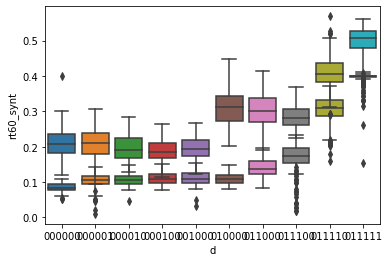

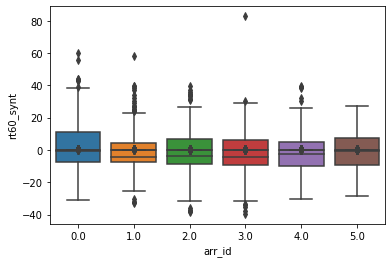

In [102]:
plt.figure()
x = 'd'
y = 'rt60_real'
hue = None
col = None
row = None
sns.boxplot(x=x, y=y, hue=hue, data=df)
y = 'rt60_synt'
sns.boxplot(x=x, y=y, hue=hue, data=df)


plt.figure()
x = 'arr_id'
y = 'ddr_real'
hue = None
col = None
row = None
sns.boxplot(x=x, y=y, hue=hue, data=df)
y = 'ddr_synt'
sns.boxplot(x=x, y=y, hue=hue, data=df)